# Students' Social Network Profile Clustering

## Import package(s)

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import mean_squared_log_error

import scipy.cluster.hierarchy as sch

import seaborn as sns
import matplotlib.pyplot as plt

## Load and clean data

In [2]:
file_path = '../../03_Clustering_Marketing.csv'

df = pd.read_csv(file_path)

og_df = df.copy(deep=True)
df.head()

,gradyear,gender,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2007,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2007,F,17.41,49,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2007,F,17.511,41,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
3,2006,F,NaN,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2008,F,16.657,1,0,0,0,0,0,1,...,0,0,0,3,0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gradyear         15000 non-null  int64 
 1   gender           13663 non-null  object
 2   age              12504 non-null  object
 3   NumberOffriends  15000 non-null  int64 
 4   basketball       15000 non-null  int64 
 5   football         15000 non-null  int64 
 6   soccer           15000 non-null  int64 
 7   softball         15000 non-null  int64 
 8   volleyball       15000 non-null  int64 
 9   swimming         15000 non-null  int64 
 10  cheerleading     15000 non-null  int64 
 11  baseball         15000 non-null  int64 
 12  tennis           15000 non-null  int64 
 13  sports           15000 non-null  int64 
 14  cute             15000 non-null  int64 
 15  sex              15000 non-null  int64 
 16  sexy             15000 non-null  int64 
 17  hot              15000 non-null

### First Problem: Age Is Not A Number

In [4]:
# get mask for those that can be converted
def is_float_convertable(x):
    try:
        a = float(x)
        return True
    except:
        return False

mask_can_convert_to_float = df.loc[:, 'age'].apply(lambda x: is_float_convertable(x))

invalid_float_rows = df[~mask_can_convert_to_float]

invalid_float_rows.head()

,gradyear,gender,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
428,2007,M,18. Jul,29,1,1,2,0,2,2,...,0,0,1,0,0,0,0,0,0,0
598,2008,F,17. Jun,57,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
671,2009,F,15. Mai,9,2,0,0,0,0,0,...,2,0,1,0,0,0,0,0,0,0
701,2009,F,16. Feb,24,1,0,1,0,1,0,...,0,0,0,4,0,0,1,0,0,0
771,2006,F,18. Apr,34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
impure_age = len(invalid_float_rows)
print('Number of not valid age: {}'.format(impure_age))

Number of not valid age: 276


Strategy for dealing with this kind of data impurity
- We cannot be sure when these people were born
- Our best bet is to treat this as a unknown value
- Change this value to NaN

In [6]:
df.loc[~mask_can_convert_to_float, ['age']] = np.NaN

## Second "problem": Missing gender

Actually this is not a problem, people have the right to not divulge their gender
- For now, we create another category NA for gender
- In future, our website will have a category for people who wishes to not state their gender

In [7]:
unknown_gender = df.loc[~df['gender'].isin(['M', 'F']), :].shape[0]
print('Number of people does not divulge their gender: {}'.format(unknown_gender))

# Change value to NA
df.loc[~df['gender'].isin(['M', 'F']), ['gender']] = 'NA'

Number of people does not divulge their gender: 1337


### Change to float

In [8]:
dtype_dict = {
    'gradyear': np.float64, 'gender': str, 'age': np.float64, 'NumberOffriends': np.float64, 
    'basketball': np.float64, 'football': np.float64, 'soccer': np.float64, 'softball': np.float64, 
    'volleyball': np.float64, 'swimming': np.float64, 'cheerleading': np.float64, 'baseball': np.float64, 
    'tennis': np.float64, 'sports': np.float64, 'cute': np.float64, 'sex': np.float64, 'sexy': np.float64, 
    'hot': np.float64, 'kissed': np.float64, 'dance': np.float64, 'band': np.float64, 'marching': np.float64, 
    'music': np.float64, 'rock': np.float64, 'god': np.float64, 'church': np.float64, 'jesus': np.float64, 
    'bible': np.float64, 'hair': np.float64, 'dress': np.float64, 'blonde': np.float64, 'mall': np.float64, 
    'shopping': np.float64, 'clothes': np.float64, 'hollister': np.float64, 'abercrombie': np.float64, 
    'die': np.float64, 'death': np.float64, 'drunk': np.float64, 'drugs': np.float64,
}
# change to float64 to avoid warning
df = df.astype(dtype_dict)

### Plot histogram for age, NumberOffriends

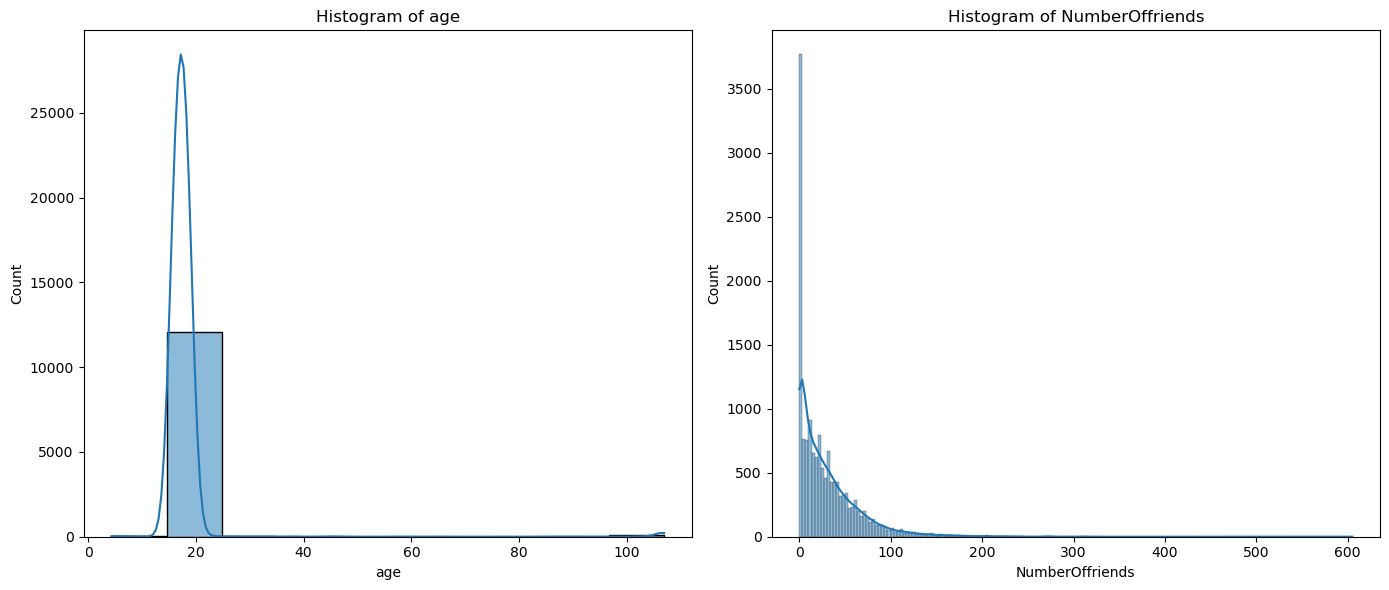

In [9]:
draw_hist = ['age', 'NumberOffriends']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(df['age'], bins=10, kde=True, ax=axes[0])
axes[0].set_title("Histogram of age")
sns.histplot(df['NumberOffriends'], kde=True, ax=axes[1])
axes[1].set_title("Histogram of NumberOffriends")

# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()

Based on those graph, we will replace NaN of age to median, of NumberOffriends to mode (which is 0)

In [10]:
age_median = df.loc[:, ['age']].median(axis=0, skipna=True).iloc[0]
friends_mode = df.loc[:, ['NumberOffriends']].mode(axis=0).iloc[0, 0]

df = df.fillna({'age': age_median, 'NumberOffriends': friends_mode})

### Missing value for gradyear
There is no missing data the gradyear, but just in case there are, we will replace those with the median value

In [11]:
gradyr_median = df.loc[:, ['gradyear']].median(axis=0, skipna=True).iloc[0]

df = df.fillna({'gradyear': gradyr_median})

### Missing frequency value
There is no missing data the frequency of keywords in post, but just in case there are, we will replace those with 0

In [12]:
# we already fill everything else at this point
df = df.fillna(0)

## Feature processing

### Split train test

In [13]:
## split train test
X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)

### Encode categorical data

In [14]:
# create one hot encoder object
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# set output
ohe.set_output(transform='pandas')

one_hot_cols = ['gender']
ohe.fit(X_train.loc[:, one_hot_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [15]:
# Transfrom
ohe_res_train = ohe.transform(X_train.loc[:, one_hot_cols])
ohe_res_test = ohe.transform(X_test.loc[:, one_hot_cols])

In [16]:
# drop old columns
X_train = X_train.drop(one_hot_cols, axis=1)
X_test = X_test.drop(one_hot_cols, axis=1)
# add new categorical columns
X_train = pd.concat([X_train, ohe_res_train], axis=1)
X_test = pd.concat([X_test, ohe_res_test], axis=1)

### Scale feature

In [17]:
# just for gradyear
mms = MinMaxScaler()
# for word frequency
sts = StandardScaler()

# set output
mms.set_output(transform='pandas')
sts.set_output(transform='pandas')

mms.fit(X_train.loc[:, ['gradyear']])
# the first 2 columns are gradyear, gender
sts.fit(X_train.loc[:, list(dtype_dict.keys())[4:]])

StandardScaler()

In [18]:
# Transfrom
mms_res_train = mms.transform(X_train.loc[:, ['gradyear']])
mms_res_test = mms.transform(X_test.loc[:, ['gradyear']])

sts_res_train = sts.transform(X_train.loc[:, list(dtype_dict.keys())[4:]])
sts_res_test = sts.transform(X_test.loc[:, list(dtype_dict.keys())[4:]])

In [19]:
X_train['gradyear'] = mms_res_train
X_test['gradyear'] = mms_res_test
X_train[list(dtype_dict.keys())[4:]] = sts_res_train
X_test[list(dtype_dict.keys())[4:]] = sts_res_test

In [20]:
X_train.head()

,gradyear,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,...,clothes,hollister,abercrombie,die,death,drunk,drugs,gender_F,gender_M,gender_NA
11797,0.333333,17.886,33.0,-0.334297,1.030280,10.802611,-0.214149,-0.222076,-0.236741,-0.207154,...,3.900791,-0.201076,-0.177905,-0.303520,-0.259418,4.415845,-0.179640,0.0,1.0,0.0
5899,0.666667,17.295,49.0,-0.334297,-0.363964,-0.243649,-0.214149,-0.222076,-0.236741,-0.207154,...,-0.308263,-0.201076,-0.177905,-0.303520,-0.259418,-0.216392,-0.179640,1.0,0.0,0.0
9513,0.333333,17.459,0.0,0.906028,-0.363964,-0.243649,-0.214149,-0.222076,1.497931,-0.207154,...,1.796264,-0.201076,-0.177905,-0.303520,-0.259418,-0.216392,-0.179640,1.0,0.0,0.0
1572,0.666667,16.876,36.0,-0.334297,-0.363964,-0.243649,-0.214149,-0.222076,-0.236741,-0.207154,...,-0.308263,-0.201076,-0.177905,1.337553,-0.259418,-0.216392,-0.179640,1.0,0.0,0.0
12995,0.333333,18.374,32.0,2.146353,-0.363964,5.279481,-0.214149,-0.222076,-0.236741,-0.207154,...,-0.308263,-0.201076,-0.177905,-0.303520,-0.259418,-0.216392,2.882411,0.0,0.0,1.0


## Model training

### Hierachical clustering

Text(0, 0.5, 'Euclidean distance')

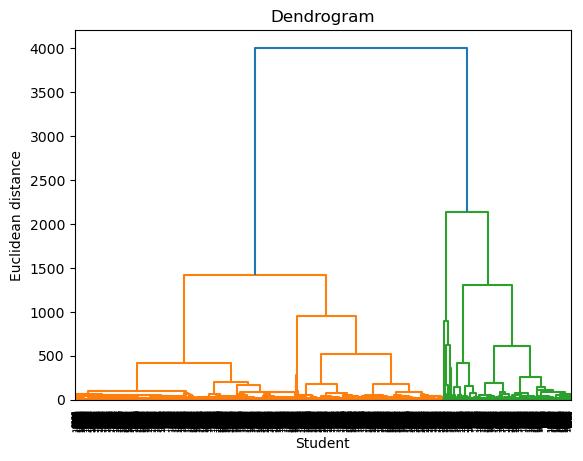

In [24]:
#using the dendrogram to pick the number of clusters
dendrogram = sch.dendrogram(sch.linkage(X_train, method = 'ward'))
f = plt.figure(1)
plt.title('Dendrogram')
plt.xlabel('Student')
plt.ylabel('Euclidean distance')

Lets create 7 clusters

In [25]:
# number of cluster
n_clus = 7
hc = AgglomerativeClustering(n_clusters=n_clus, metric='euclidean', linkage='ward')
y_hc = hc.fit_predict(X_train)

In [26]:
unique_elements, counts = np.unique(y_hc, return_counts=True)

count_group_hc = dict(zip(unique_elements, counts))
print(count_group_hc)

{0: 174, 1: 1958, 2: 3078, 3: 4665, 4: 558, 5: 64, 6: 3}


### KMeans

Text(0, 0.5, 'WCSS')

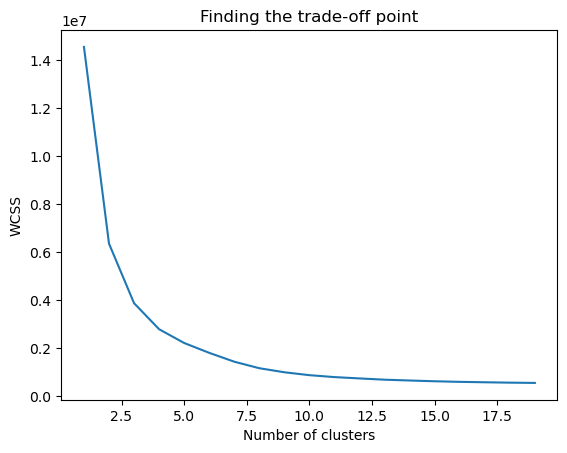

In [21]:
#find K that when K increase, the prefermance does not increase as much as before to select K
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

f = plt.figure(1)
plt.plot(range(1, 20), wcss)
plt.title('Finding the trade-off point')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

By looking at that graph, it seems that from 5 clusters onwards, there was not a big improve. Lets settle on 5

In [22]:
#K-means
k_clus = 5
kmeans = KMeans(n_clusters=k_clus, init='k-means++', max_iter=500, n_init=10, random_state=33)
y_kmeans = kmeans.fit_predict(X_train)

In [23]:
unique_elements, counts = np.unique(y_kmeans, return_counts=True)

count_group_km = dict(zip(unique_elements, counts))
print(count_group_km)

{0: 3177, 1: 1605, 2: 5237, 3: 422, 4: 59}
